In [2]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
from tempfile import TemporaryFile
from PIL import Image, ImageEnhance
from os import listdir
import imghdr
from skimage.transform import rotate, AffineTransform, warp
from skimage import filters
from torchvision import transforms
import cv2
import scipy
import random

In [ ]:
rmdir './Data_full/.ipynb_checkpoints'

In [3]:
### Load Data and Handle Preprocessing

# Input: Folder with all the .png images
# Output: Images and respective labels
# Works?: Yes
def loadImages(path):
    imagesList = listdir(path)
    imgs = []
    labels = []
    for image in imagesList:
      if imghdr.what(path + image) == 'png':
        if (image[6].isalpha()): # only add 5 of each image, only add alphabetical values
          img = Image.open(path + image)
          imgs.append(img)
          labels.append(ord(image[6]) - ord('a')) # assumes that filename structure is 'handx_[label]_....'
    return imgs, labels

# Convert png img array to array np arrays
# Input: PNG image array
# Output: a list of numpy images
# Works?: Yes
def ImagesToArray(imgs):
  imgs_array = []
  for img in imgs:
    img_array = np.array(img)
    imgs_array.append(img_array)
  return imgs_array

# Zero pad all images
# Input: list of numpy images
# Output: numpy array of N 600x600 images with 3 channels
# Works?: Yes, but might not be necessary
def shape600(x):
  reshaped_array = np.zeros((len(x), 600, 600, 3))
  for i, img in enumerate(x):
    x_pad_width = (600 - img.shape[0])//2
    y_pad_width = (600 - img.shape[1])//2
    reshaped_array[i,:,:,:] = np.pad(img, ((x_pad_width, x_pad_width + (img.shape[0])%2), (y_pad_width, y_pad_width+(img.shape[1]%2)), (0,0)), constant_values=img[0][0][0])
  return reshaped_array

# Normalizes images... based on... what?
# Input: image array
# Output: a list of numpy arrays
# Works?: ??? Not entirely sure if this is the correct method though, based on online implementations of AlexNet
def Normalize(imgs):
  new_imgs = []
  for img in imgs:
      # flat_img = img.flatten()
      m = np.mean(img)
      std = np.std(img)
      img = (img-m)/std
      new_imgs.append(img)
  return new_imgs

################### DATA AUGMENTATION ######################
# x is input image, sd is how much to blur
def blur(imgs, sd=1):
  filtered_img = np.zeros((imgs.shape[0], 600, 600, 3))
  for i in range(imgs.shape[0]):
    filtered_img[i,:,:,:] = skimage.filters.gaussian(imgs[i,:,:,:], sigma=sd)
    #filtered_img.save('./Filter_gaussian/img_' + i + '_gaussianfilt.png')
  return filtered_img

def Scale(imgs):
  scaled_images = np.zeros((len(imgs), 600, 600, 3))
  for i, img in enumerate(imgs):
    # ratio = random.randrange(.2, .5, .1)
    ratio = random.choice([0.1, 0.2, 0.3, 0.4])
    x = int(ratio * 600 / 2)
    scaled = img[x:600-x, x:600-x]
    # scaled = cv2.imread(scaled)
    res = cv2.resize(scaled, dsize=(600, 600), interpolation=cv2.INTER_CUBIC)
    scaled_images[i] = res
  return scaled_images
    # final.save('./Crop/img_' + str(i) + '_scale.png')

def Rotate30(imgs): 
  rot30_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  for i, img in enumerate(imgs): 
    rand_dir = random.choice([-1, 1])
    new_img = rotate(img, rand_dir * 30) 
    rot30_imgs[i, :] = new_img
  return rot30_imgs

def VerticalFlip(imgs): 
  flip_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  for i, img in enumerate(imgs): 
    new_img = np.fliplr(img)
    flip_imgs[i, :, :, :] = new_img
  return flip_imgs

def Translation(imgs): 
  trans_imgs = np.empty([imgs.shape[0], imgs.shape[1], imgs.shape[2], imgs.shape[3]])
  for i, img in enumerate(imgs): 
    rand_x = random.randrange(-150, 150, 50)
    rand_y = random.randrange(-150, 150, 50)
    transform = AffineTransform(translation=(rand_x,rand_y))
    new_img = warp(img,transform, mode="constant")  
    trans_imgs[i, :] = new_img
  return trans_imgs
####################################################

# load png_images from Data_full foler
path = "./Data_full/"

# images in an array named imgs
imgs, labels = loadImages(path)

# Step 1 convert png_images to np arrays
imgs_array_before = ImagesToArray(imgs)

def Augment(imgs_array_before, labels):
  # Step 2 Normalize images
  imgs_array_normalize = Normalize(imgs_array_before)

  # Step 3 Reshape the images
  imgs_array_reshaped = shape600(imgs_array_normalize)

  # Step 4 Blur the images
  blurred_imgs = blur(imgs_array_reshaped, 10)

  # Step 5 Scale the images
  scaled_imgs = Scale(imgs_array_reshaped)

  # Step 6 Flip the images
  flipped_imgs = VerticalFlip(imgs_array_reshaped)

  # Step 7 Add translation to images
  translated_imgs = Translation(imgs_array_reshaped)

  # Step 8 Rotate 30 Degrees
  rotated30_imgs = Rotate30(imgs_array_reshaped)

  # Step 10 combine all augmented images to np array of shape((num_augmentations + 1) * num_images, 600, 600, 3)
  final_imgs_temp = np.concatenate((imgs_array_reshaped, blurred_imgs, scaled_imgs, translated_imgs, flipped_imgs, rotated30_imgs), 0)
  labels_temp = np.concatenate((labels, labels, labels, labels, labels, labels), 0)
  #print(final_imgs_temp.shape)
  # np.save('../FinalImages/imgs' + str(i) + '.npy', final_imgs_temp)
  # Show the progression of images for each step
  # fig, ax = plt.subplots(1, 11, figsize=(15,10))
  # ax[0].imshow(imgs_array_before[0]) # Step 1
  # ax[1].imshow(imgs_array_normalize[0]) # Step 2
  # ax[2].imshow(imgs_array_reshaped[0]) # Step 3
  # ax[3].imshow(blurred_imgs[0]) # Step 4
  # ax[4].imshow(scaled_imgs[0]) # Step 5
  # ax[5].imshow(light_imgs[0]) # Step 6
  # ax[6].imshow(dark_imgs[0]) # Step 6
  # ax[7].imshow(flipped_imgs[0]) # Step 7
  # ax[8].imshow(translated_imgs[0]) # Step 8
  # ax[9].imshow(rotated30_imgs[0]) # Step 9
  # ax[10].imshow(rotatedNeg30_imgs[0]) # Step 9
  return final_imgs_temp, labels_temp


In [39]:
final_imgs = np.empty([0, 600, 600, 3])
final_labels = np.empty([0])
n = int(130/65)
for i in range(n):
  [final_imgs_temp, labels_temp] = Augment(imgs_array_before[i * 65:(i + 1) * 65], labels[i * 65:(i + 1) * 65])
  final_imgs = np.concatenate((final_imgs, final_imgs_temp), 0)
  final_labels = np.concatenate((final_labels, labels_temp))
  
  if (n % 10 == 0):
    print(n)

print(final_imgs.shape)
print(final_labels.shape)
np.save('./FinalImages/imgs.npy', final_imgs)
np.save('./FinalImages/labels.npy', final_labels)

/Users/aidanaug/Library/Python/3.8/lib/python/site-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


(780, 600, 600, 3)
(780,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.0


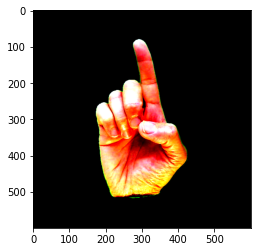

In [40]:
augmented_data = np.load("./FinalImages/imgs.npy")
labels = np.load("./FinalImages/labels.npy")
plt.imshow(augmented_data[1,:,:])
print(labels[1])

In [4]:
## Model Implementation
import sys
import csv
import os
import numpy as np
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage
from skimage.transform import rotate
from sklearn.model_selection import train_test_split

In [5]:
# AlexNet Implementation
# Expects input of size 227 at least, for the kernels to work

class AlexNet(torch.nn.Module):

    def __init__(self, input_height=227, input_width=227, n_classes=26, channels=3):
        super().__init__()

        # Initialize the parameters of the model
        self.input_height = input_height
        self.input_width = input_width
        self.n_classes = n_classes
        self.channels = channels

        # AlexNet Implementation; Same Structure with different outputs die to input
        self.model_convolution = nn.Sequential(
            nn.Conv2d(in_channels=channels,out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=96,out_channels=256,kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=256,out_channels=384,kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=384,out_channels=384,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=3, stride=2)
        )

        # The dense network architecture. Assumes input has 4096 nodes, or 4x4x256
        self.model_dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216, 4096),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            nn.Linear(4096, n_classes)
        )

    def forward(self, x):
        x = x.reshape(x.shape[0], self.channels, self.input_height, self.input_width)
        x = self.model_convolution(x)
        x = self.model_dense(x)
        return x
    
        

In [6]:

def accuracy(y : np.ndarray, y_hat : np.ndarray) -> np.float64:
    """Calculate the simple accuracy given two numpy vectors, each with int values
    corresponding to each class.

    Args:
        y (np.ndarray): actual value
        y_hat (np.ndarray): predicted value

    Returns:
        np.float64: accuracy
    """
    ### TODO Implement accuracy function
    N = len(y)   
    number_correct = N - np.count_nonzero(y - y_hat)
    accuracy = number_correct / N
    return accuracy


def approx_train_acc_and_loss(model, train_data : np.ndarray, train_labels : np.ndarray) -> np.float64:
    """Given a model, training data and its associated labels, calculate the simple accuracy when the 
    model is applied to the training dataset.
    This function is meant to be run during training to evaluate model training accuracy during training.

    Args:
        model (pytorch model): model class object.
        train_data (np.ndarray): training data
        train_labels (np.ndarray): training labels

    Returns:
        np.float64: simple accuracy
    """
    idxs = np.random.choice(len(train_data), len(train_data)//2, replace=False)
    x = torch.from_numpy(train_data[idxs].astype(np.float32))
    y = torch.from_numpy(train_labels[idxs].astype(int))
    logits = model(x)
    #print(logits)
    #print(x.shape)
    #print(x[0])
    #print(logits.shape)
    #print(y.shape)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    #print(y_pred.shape)
    #print(train_labels[idxs].shape)
    #print(torch.max(logits, 1))
    #print("actual:" + str(train_labels[idxs]))
    #print("predicted:" + str(y_pred))
    return accuracy(train_labels[idxs], y_pred.numpy()), loss.item()


def dev_acc_and_loss(model, dev_data : np.ndarray, dev_labels : np.ndarray) -> np.float64:
    """Given a model, a validation dataset and its associated labels, calcualte the simple accuracy when the
    model is applied to the validation dataset.
    This function is meant to be run during training to evaluate model validation accuracy.

    Args:
        model (pytorch model): model class obj
        dev_data (np.ndarray): validation data
        dev_labels (np.ndarray): validation labels

    Returns:
        np.float64: simple validation accuracy
    """
    x = torch.from_numpy(dev_data.astype(np.float32))
    y = torch.from_numpy(dev_labels.astype(int))
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    y_pred = torch.max(logits, 1)[1]
    return accuracy(dev_labels, y_pred.numpy()), loss.item()

In [89]:
print(len(imgs))




650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(650, 3, 227, 227)
j


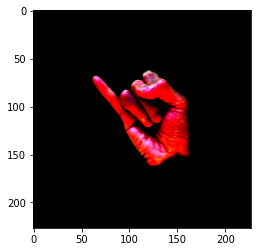

In [155]:
## Preprocess Images using online package

preprocess = transforms.Compose([
  transforms.Resize(100),
  transforms.CenterCrop(227),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms_array = np.zeros((len(imgs), 3, 227, 227))
for i in range(len(imgs)):
  temp = preprocess(imgs[i])
  transforms_array[i,:,:,:] = temp

  
print(transforms_array.shape)
output = transforms_array[51,:,:,:]
output = np.swapaxes(output, 0, 2)
output = np.swapaxes(output, 0, 1)

plt.imshow(output)
print(labels[51])

In [195]:
LEARNING_RATE = 0.1
BATCH_SIZE = 100
EPOCHS = 1000
HEIGHT = 227
WIDTH = 227
CHANNELS = 3

model = AlexNet(227, 227, 26, 3)

### TODO (OPTIONAL) : you can change the choice of optimizer here if you wish.
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

# load png_images
path = "./Data_full/"

# images in an array named imgs
imgs, labels = loadImages(path)

labels = np.asarray(labels)

## Preprocess Images using online package
imgs_array_before = ImagesToArray(imgs)

preprocess = transforms.Compose([
  transforms.Resize(100),
  transforms.CenterCrop(227),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms_array = np.zeros((len(imgs), 3, 227, 227))
for i in range(len(imgs)):
  temp = preprocess(imgs[i])
  transforms_array[i,:,:,:] = temp
  
transforms_array = np.swapaxes(transforms_array,1, 3)
transforms_array = np.swapaxes(transforms_array,1, 2)
print(transforms_array.shape)

############################

## Preprocess images Using our functions
# imgs_array_normalize = Normalize(imgs_array_before)
# imgs_array_reshaped = shape600(imgs_array_normalize)

## Use Augmented Data
# augmented_data = np.load("./FinalImages/imgs.npy")
# labels = np.load("./FinalImages/labels.npy")

############################

## Actually create the train and test dev splits. Flatten before use.
data_train, data_dev, labels_train, labels_dev = train_test_split(transforms_array, labels, test_size=0.20, random_state=42)

flat_train_imgs = np.reshape(data_train, (data_train.shape[0], HEIGHT * WIDTH, CHANNELS))
flat_train_imgs = np.swapaxes(flat_train_imgs, 1, 2)
print(flat_train_imgs.shape)
flat_dev_imgs = np.reshape(data_dev, (data_dev.shape[0], HEIGHT * WIDTH, CHANNELS))
flat_dev_imgs = np.swapaxes(flat_dev_imgs, 1, 2)


for step in range(EPOCHS):
    i = np.random.choice(flat_train_imgs.shape[0], size=BATCH_SIZE, replace=False)
    x = torch.from_numpy(flat_train_imgs[i].astype(np.float32))
    y = torch.from_numpy(labels_train[i].astype(int))
    
    
    # Forward pass: Get logits for x
    logits = model(x)
    # Compute loss
    loss = F.cross_entropy(logits, y)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # log model performance every 10 epochs
    if step % 100 == 0:
        train_acc, train_loss = approx_train_acc_and_loss(model, flat_train_imgs, labels_train)
        dev_acc, dev_loss = dev_acc_and_loss(model, flat_dev_imgs, labels_dev)
        step_metrics = {
            'step': step, 
            'train_loss': loss.item(), 
            'train_acc': train_acc,
            'dev_loss': dev_loss,
            'dev_acc': dev_acc
        }

        print(f"On step {step}:\tTrain loss {train_loss}\t|Train acc {train_acc}\t|\tDev acc is {dev_acc}")
        

print("Training completed, saving model with name AlexNet")


(650, 227, 227, 3)
(520, 3, 51529)
On step 0:	Train loss 1102655006965760.0	|Train acc 0.03461538461538462	|	Dev acc is 0.023076923076923078
On step 100:	Train loss 3.2544336318969727	|Train acc 0.05	|	Dev acc is 0.023076923076923078
On step 200:	Train loss 3.262497663497925	|Train acc 0.046153846153846156	|	Dev acc is 0.023076923076923078
On step 300:	Train loss 3.2582955360412598	|Train acc 0.03076923076923077	|	Dev acc is 0.023076923076923078
On step 400:	Train loss 3.2655344009399414	|Train acc 0.038461538461538464	|	Dev acc is 0.015384615384615385
On step 500:	Train loss 3.264941692352295	|Train acc 0.046153846153846156	|	Dev acc is 0.03076923076923077
On step 600:	Train loss 3.2591605186462402	|Train acc 0.03076923076923077	|	Dev acc is 0.038461538461538464
On step 700:	Train loss 3.2490222454071045	|Train acc 0.05	|	Dev acc is 0.023076923076923078
On step 800:	Train loss 3.2675044536590576	|Train acc 0.03461538461538462	|	Dev acc is 0.015384615384615385
On step 900:	Train loss 3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


17


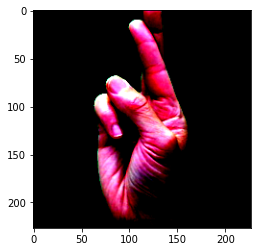

In [192]:
flat_train_imgs = np.reshape(data_train, (data_train.shape[0], HEIGHT * WIDTH, CHANNELS))
flat_train_imgs = np.swapaxes(flat_train_imgs, 1, 2)

x = flat_train_imgs.reshape(flat_train_imgs.shape[0], 3, 227, 227)
x = np.swapaxes(x, 1, 2)
x = np.swapaxes(x, 2, 3)
print(labels_train[2])
plt.imshow(x[2])

In [187]:
x = torch.from_numpy(flat_train_imgs[1:2,:,:].astype(np.float32))
print(x.shape)
logits = model(x)
print(logits)
print(torch.max(logits, 1))
print(labels[1])

x = torch.from_numpy(flat_train_imgs[2:3,:,:].astype(np.float32))
print(x.shape)
logits = model(x)
print(logits)
print(torch.max(logits, 1))
print(labels[2])

x = torch.from_numpy(flat_train_imgs[10:11,:,:].astype(np.float32))
print(x.shape)
logits = model(x)
print(logits)
print(torch.max(logits, 1))
print(labels[10])

torch.Size([1, 3, 51529])
tensor([[22.3379, 19.4320, 15.6433, 23.5658, 23.3357, 22.8972, 21.8001, 21.8458,
          2.0084, 21.2022, 21.8060, 14.2964, 21.9773, 18.1058,  8.5647, 11.0091,
         22.7084,  3.4063, 21.6075, 22.9957, 22.8599, 22.7440, 12.0392, 22.8874,
         21.7878, 23.0386]], grad_fn=<AddmmBackward0>)
torch.return_types.max(
values=tensor([23.5658], grad_fn=<MaxBackward0>),
indices=tensor([3]))
1
torch.Size([1, 3, 51529])
tensor([[86.6529, 75.2568, 61.6370, 91.7535, 90.7961, 88.8951, 84.5644, 84.7277,
          8.2338, 82.1805, 84.5605, 55.5996, 85.3888, 71.0820, 34.1825, 42.8481,
         88.2188, 13.0156, 83.8144, 89.5013, 88.7587, 88.3529, 46.8025, 88.9136,
         84.5465, 89.6681]], grad_fn=<AddmmBackward0>)
torch.return_types.max(
values=tensor([91.7535], grad_fn=<MaxBackward0>),
indices=tensor([3]))
13
torch.Size([1, 3, 51529])
tensor([[3.0490, 2.6339, 2.0029, 3.1965, 3.1887, 3.1248, 2.9663, 3.0021, 0.2406,
         2.9075, 2.9791, 1.9476, 2.9988, 2.3429, 1

[4 0 4 ... 2 1 5]


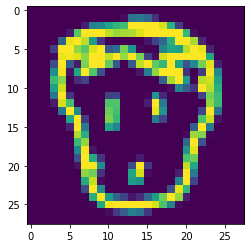

In [196]:
x = np.load("fruit_images.npy")
y = np.load("fruit_labels.npy")
plt.imshow(x[0])
print(y)

In [7]:
LEARNING_RATE = 0.1
BATCH_SIZE = 100
EPOCHS = 1000
HEIGHT = 227
WIDTH = 227
CHANNELS = 3

model = AlexNet(227, 227, 26, 3)

### TODO (OPTIONAL) : you can change the choice of optimizer here if you wish.
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

# load png_images
path = "./Data_full/"

# images in an array named imgs
imgs, labels = loadImages(path)

labels = np.asarray(labels)

## Preprocess Images using online package
imgs_array_before = ImagesToArray(imgs)

preprocess = transforms.Compose([
  transforms.Resize(100),
  transforms.CenterCrop(227),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms_array = np.zeros((len(imgs), 3, 227, 227))
for i in range(len(imgs)):
  temp = preprocess(imgs[i])
  transforms_array[i,:,:,:] = temp
  
transforms_array = np.swapaxes(transforms_array,1, 3)
transforms_array = np.swapaxes(transforms_array,1, 2)
print(transforms_array.shape)

############################

## Preprocess images Using our functions
# imgs_array_normalize = Normalize(imgs_array_before)
# imgs_array_reshaped = shape600(imgs_array_normalize)

## Use Augmented Data
# augmented_data = np.load("./FinalImages/imgs.npy")
# labels = np.load("./FinalImages/labels.npy")

############################

## Actually create the train and test dev splits. Flatten before use.
data_train, data_dev, labels_train, labels_dev = train_test_split(transforms_array, labels, test_size=0.20, random_state=42)

flat_train_imgs = np.reshape(data_train, (data_train.shape[0], HEIGHT * WIDTH, CHANNELS))
flat_train_imgs = np.swapaxes(flat_train_imgs, 1, 2)
print(flat_train_imgs.shape)
flat_dev_imgs = np.reshape(data_dev, (data_dev.shape[0], HEIGHT * WIDTH, CHANNELS))
flat_dev_imgs = np.swapaxes(flat_dev_imgs, 1, 2)

(650, 227, 227, 3)
(520, 3, 51529)


# Let's Take this step by step:

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

Files already downloaded and verified
Files already downloaded and verified
ship
<class 'torch.Tensor'>
torch.Size([3, 32, 32])
1st dimension <class 'tuple'>
2nd dimension <class 'torch.Tensor'>
3rd dimension <class 'torch.Tensor'>
4th dimension <class 'torch.Tensor'>
5th dimension <class 'torch.Tensor'>


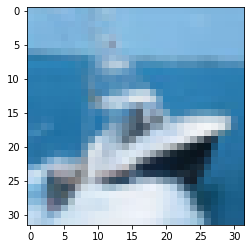

In [144]:
## Example online
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


print(classes[trainset[8][1]])
print(type(trainset[8][0][0][0][0]))
imgshow = trainset[8][0] / 2 + 0.5
print(imgshow.shape)

imgshow = imgshow.numpy()

print(f"1st dimension {type(trainset[8])}")
print(f"2nd dimension {type(trainset[8][0])}")
print(f"3rd dimension {type(trainset[8][0][0])}")
print(f"4th dimension {type(trainset[8][0][0][0])}")
print(f"5th dimension {type(trainset[8][0][0][0][0])}")

plt.imshow(np.transpose(imgshow, (1, 2, 0)))

## Basically, here is what I got from the online dataset:
# 1. The first index determines which image sample. Each sample is stored as a tuple
# 2. The second is the label, which in this case is a car
# 3. The next is the channels
# 4. The fourth is the x dimension of the image
# 5. The fifth is the y dimension of the image

(3, 32, 32)


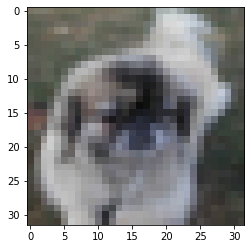

dog  


In [145]:
#visualize images

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    print(npimg.shape)
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [146]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [147]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [149]:
# Train the network
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

tensor(1)
tensor(1)
tensor(7)
tensor(8)
tensor(8)
tensor(9)
tensor(0)
tensor(3)
tensor(4)
tensor(5)
tensor(2)
tensor(1)
tensor(6)
tensor(8)
tensor(1)
tensor(3)
tensor(3)
tensor(6)
tensor(2)
tensor(1)
tensor(4)
tensor(4)
tensor(0)
tensor(4)
tensor(1)
tensor(6)
tensor(9)
tensor(4)
tensor(0)
tensor(2)
tensor(8)
tensor(6)
tensor(0)
tensor(5)
tensor(0)
tensor(7)
tensor(2)
tensor(8)
tensor(1)
tensor(0)
tensor(0)
tensor(8)
tensor(0)
tensor(5)
tensor(6)
tensor(9)
tensor(1)
tensor(4)
tensor(2)
tensor(1)
tensor(0)
tensor(7)
tensor(1)
tensor(9)
tensor(9)
tensor(1)
tensor(4)
tensor(2)
tensor(5)
tensor(8)
tensor(6)
tensor(0)
tensor(0)
tensor(7)
tensor(7)
tensor(4)
tensor(8)
tensor(6)
tensor(6)
tensor(4)
tensor(4)
tensor(7)
tensor(3)
tensor(1)
tensor(1)
tensor(3)
tensor(0)
tensor(5)
tensor(7)
tensor(2)
tensor(6)
tensor(3)
tensor(2)
tensor(7)
tensor(6)
tensor(5)
tensor(9)
tensor(0)
tensor(1)
tensor(2)
tensor(3)
tensor(0)
tensor(7)
tensor(7)
tensor(6)
tensor(7)
tensor(2)
tensor(6)
tensor(3)
tensor(1)


[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 

# Now, let's apply this to our dataset

In [168]:
import string

Num of Training Instances: 520
Num of Testing Instances: 130
Shape of Sample Instances: torch.Size([3, 32, 32])
1st dimension <class 'tuple'>
2nd dimension <class 'torch.Tensor'>
3rd dimension <class 'torch.Tensor'>
4th dimension <class 'torch.Tensor'>
5th dimension <class 'torch.Tensor'>
Label: W


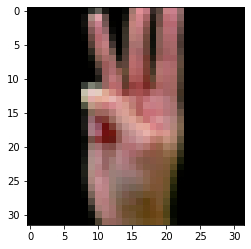

In [240]:
batch_size = 4
channels = 3
## CAN CHANGE THIS LATER!!!!!!!!
crop_size = 32
train_split = 0.8
test_split = 0.2

# images in an array named imgs. 
# IDEALLY, WE DO ALL THE PREPROCESSING BEFOREHAND AND THEN RUN THE FOLLOWING STEPS
imgs, labels = loadImages(path)


### IDEALLY, WE DO ALL THE PREPROCESSING BEFOREHAND AND THEN RUN THE FOLLOWING STEPS

## First, we preprocess the image, essentially resizing and cropping.
preprocess = transforms.Compose([
  transforms.Resize(15), # Hyperparameter
  transforms.CenterCrop(crop_size),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Second, we must create the training and testing data. Format it so it's same as using CIFAR dataset
transforms_array = np.zeros((len(imgs), channels, crop_size, crop_size))
for i in range(len(imgs)):
  temp = preprocess(imgs[i])
  transforms_array[i,:,:,:] = temp

trainset, testset, labels_train, labels_test = train_test_split(transforms_array, labels, test_size=test_split, random_state=42)

## Create the training dataand trainloader
training_data = []
for i in range(len(trainset)):
  sample = (torch.Tensor(trainset[i,:,:,:]), labels_train[i])
  training_data.append(sample)

trainloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

## Create the testing data and testloader
testing_data = []
for i in range(len(testset)):
  sample = (torch.Tensor(testset[i,:,:,:]), labels_test[i])
  testing_data.append(sample)

testloader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


# Define the classes
classes = list(string.ascii_uppercase)

## Print some stats/info about the data
print(f"Num of Training Instances: {len(training_data)}")
print(f"Num of Testing Instances: {len(testing_data)}")
print(f"Shape of Sample Instances: {training_data[0][0].shape}")
print(f"1st dimension {type(training_data[8])}")
print(f"2nd dimension {type(training_data[8][0])}")
print(f"3rd dimension {type(training_data[8][0][0])}")
print(f"4th dimension {type(training_data[8][0][0][0])}")
print(f"5th dimension {type(training_data[8][0][0][0][0])}")

# Unnormalize the image before showing!
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

inv_tensor = invTrans(training_data[8][0])
print(f"Label: {classes[training_data[8][1]]}")
plt.imshow(np.transpose(inv_tensor, (1, 2, 0)));



## View sample iamges and their respective labels

torch.Size([3, 36, 138])


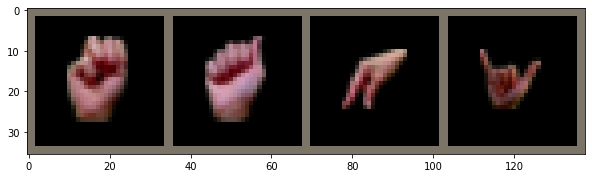

labels: M     A     Q     Y    


In [241]:
def imshow(img):
    img = invTrans(img)
    print(img.shape)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
# print labels
print("labels: " + ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Implement the model: CAN DEF CHANGE THIS PART

In [243]:
import torch.nn as nn
import torch.nn.functional as F

# Right now, this model is based on input size of 32 x 32. Must adjust kernels + padding + strides
# if we want to use a different input size
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 26)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## Train the model

In [245]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [246]:

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 0.016
[1,   110] loss: 0.163
[2,    10] loss: 0.016
[2,   110] loss: 0.162
[3,    10] loss: 0.016
[3,   110] loss: 0.161
[4,    10] loss: 0.016
[4,   110] loss: 0.156
[5,    10] loss: 0.014
[5,   110] loss: 0.128
[6,    10] loss: 0.009
[6,   110] loss: 0.066
[7,    10] loss: 0.003
[7,   110] loss: 0.035
[8,    10] loss: 0.002
[8,   110] loss: 0.024
[9,    10] loss: 0.002
[9,   110] loss: 0.013
[10,    10] loss: 0.001
[10,   110] loss: 0.012
[11,    10] loss: 0.001
[11,   110] loss: 0.008
[12,    10] loss: 0.002
[12,   110] loss: 0.006
[13,    10] loss: 0.000
[13,   110] loss: 0.005
[14,    10] loss: 0.000
[14,   110] loss: 0.002
[15,    10] loss: 0.000
[15,   110] loss: 0.001
[16,    10] loss: 0.000
[16,   110] loss: 0.002
[17,    10] loss: 0.000
[17,   110] loss: 0.002
[18,    10] loss: 0.000
[18,   110] loss: 0.001
[19,    10] loss: 0.000
[19,   110] loss: 0.001
[20,    10] loss: 0.000
[20,   110] loss: 0.000
Finished Training


# Test the model

In [247]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testset)} test images: {100 * correct // total} %')

Accuracy of the network on the 130 test images: 100 %


torch.Size([3, 36, 138])


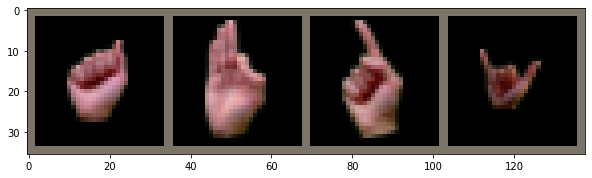

GroundTruth:  A     F     Z     Y    
Predicted:  A     F     Z     Y    


In [248]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))